# MobiML GeoTrackNet Demo

Based on: https://github.com/CIA-Oceanix/GeoTrackNet (MIT Licensed, (c) 2018 Duong Nguyen)

As presented in Nguyen, D., Vadaine, R., Hajduch, G., Garello, R. (2022). GeoTrackNet - A Maritime Anomaly Detector Using Probabilistic Neural Network Representation of AIS Tracks and A Contrario Detection. In IEEE Transactions on Intelligent Transportation Systems, 23(6).


Using data from AISDK: http://web.ais.dk/aisdata/aisdk-2018-02.zip

*It is possible to further explore maritime traffic patterns with the TrAISformer (https://github.com/CIA-Oceanix/TrAISformer), which is used for vessel trajectory prediction. The TrAISformer can be trained with AIS data and the preprocessing steps are similar to those of GeoTrackNet. However, the TrAISformer is out of the scope of MobiML and is an optional extension for the user to explore.*

## Environments

### Preprocessing

It is recommended to perform the preprocessing steps with the MobiML environment.

### Model Training

Set up a dedicated GeoTrackNet environment (PY3GPU) to train the model as instructed by Nguyen et al. (2022).

## Preprocessing

In [36]:
import numpy as np
import os
import sys
import pickle
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
from datetime import datetime, timedelta
from tqdm import tqdm

sys.path.append("../src")
from mobiml.datasets.simulated import SyntheticAIS


from mobiml.samplers import TemporalSplitter
from mobiml.preprocessing import (
    TrajectorySplitter,
    TrajectoryFilter,
    TrajectoryDownsampler,
)

In [37]:
%pwd

'/home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples'

In [38]:
# AISDK dataset
LAT, LON, SOG, COG, NAME, SHIPTYPE, NAV_STT, TIMESTAMP, TRAJ_ID = list(range(9))

EPOCH = datetime(1970, 1, 1)

SOG_MIN = 2.0
SOG_MAX = 30.0  # SOG is truncated to 30.0 knots max

# Pkl filenames
pkl_filename_train = "simulated_train.pkl"
pkl_filename_valid = "simulated_valid.pkl"
pkl_filename_test = "simulated_test.pkl"

# Path to csv files
data_path = "ais/"
csv_filename = "synthetic_vessel_2197.csv"

# Output path
out_path = "data/simulated_sample/"

### Loading data

In [39]:
path = os.path.join(data_path, csv_filename)
print(f"{datetime.now()} Loading data from {path}")
simulated = SyntheticAIS(path)  # you can specify a bounding box here to filter the area
LON_MIN, LAT_MIN, LON_MAX, LAT_MAX = simulated.get_bounds()
print(
    f"Bounding box:\nmin_lon: {LON_MIN}\nmin_lat: {LAT_MIN}\nmax_lon: {LON_MAX}\nmax_lat: {LAT_MAX}"
)

2025-11-10 12:12:09.764761 Loading data from ais/synthetic_vessel_2197.csv


/home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/src/mobiml/datasets/_dataset.py:73: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, *args, **kwargs)


2025-11-10 12:12:11.007562 Loaded DataFrame with 685275 rows.
Bounding box:
min_lon: -4.595329573979031
min_lat: 48.28227140072556
max_lon: -4.29677930526579
max_lat: 48.39802992302604


### Training data preparation

#### Temporal train/valid/test split

In [44]:
traj_ids = simulated.df["traj_id"].unique()
n_traj = len(traj_ids)

# Ratios (ajuste si besoin)
train_ratio = 0.6
valid_ratio = 0.2
# le reste -> test

# Mélange aléatoire des trajectoires (reproductible)
rng = np.random.default_rng(seed=42)
rng.shuffle(traj_ids)

# Découpage par trajectoires
n_train_traj = int(train_ratio * n_traj)
n_valid_traj = int(valid_ratio * n_traj)

train_ids = set(traj_ids[:n_train_traj])
valid_ids = set(traj_ids[n_train_traj:n_train_traj + n_valid_traj])
test_ids  = set(traj_ids[n_train_traj + n_valid_traj:])

simulated.df["split"] = 0.0
simulated.df.loc[simulated.df["traj_id"].isin(train_ids), "split"] = 1.0
simulated.df.loc[simulated.df["traj_id"].isin(valid_ids), "split"] = 2.0
simulated.df.loc[simulated.df["traj_id"].isin(test_ids),  "split"] = 3.0

In [45]:
simulated.df

,t,x,y,traj_id,speed,is_anomaly,anomaly_type,timestamp,direction,split
0,2025-10-07 06:35:45.008620,-4.376706,48.397971,1,0.465175,False,NaN,2025-10-07 06:35:45.008620,359.914081,1.0
262231,2025-10-07 06:35:45.008620,-4.505844,48.292598,1919,0.516018,False,NaN,2025-10-07 06:35:45.008620,0.135239,1.0
58962,2025-10-07 06:35:45.008620,-4.302334,48.353418,174,0.516679,False,NaN,2025-10-07 06:35:45.008620,359.926861,1.0
262382,2025-10-07 06:35:45.008620,-4.412353,48.334023,1792,0.530226,False,NaN,2025-10-07 06:35:45.008620,359.941389,2.0
58601,2025-10-07 06:35:45.008620,-4.500580,48.369485,175,0.513469,False,NaN,2025-10-07 06:35:45.008620,0.131741,1.0
...,...,...,...,...,...,...,...,...,...,...
683419,2025-11-09 16:06:18.948934,-4.491827,48.318423,1578,3.557145,False,NaN,2025-11-09 16:06:18.948934,0.020718,3.0
664746,2025-11-09 16:06:18.948934,-4.460654,48.345979,125,3.511356,False,NaN,2025-11-09 16:06:18.948934,0.010216,3.0
679994,2025-11-09 16:06:18.948934,-4.445284,48.343410,1587,2.794183,False,NaN,2025-11-09 16:06:18.948934,359.963069,1.0
674054,2025-11-09 16:06:18.948934,-4.500875,48.369105,21,0.371619,False,NaN,2025-11-09 16:06:18.948934,0.055144,1.0


In [46]:
simulated_train = simulated.df[(simulated.df["split"] == 1.0)]
simulated_valid = simulated.df[(simulated.df["split"] == 2.0)]
simulated_test = simulated.df[(simulated.df["split"] == 3.0)]

In [47]:
simulated_train

,t,x,y,traj_id,speed,is_anomaly,anomaly_type,timestamp,direction,split
0,2025-10-07 06:35:45.008620,-4.376706,48.397971,1,0.465175,False,NaN,2025-10-07 06:35:45.008620,359.914081,1.0
262231,2025-10-07 06:35:45.008620,-4.505844,48.292598,1919,0.516018,False,NaN,2025-10-07 06:35:45.008620,0.135239,1.0
58962,2025-10-07 06:35:45.008620,-4.302334,48.353418,174,0.516679,False,NaN,2025-10-07 06:35:45.008620,359.926861,1.0
58601,2025-10-07 06:35:45.008620,-4.500580,48.369485,175,0.513469,False,NaN,2025-10-07 06:35:45.008620,0.131741,1.0
58443,2025-10-07 06:35:45.008620,-4.543649,48.317403,2000,0.455361,False,NaN,2025-10-07 06:35:45.008620,0.140905,1.0
...,...,...,...,...,...,...,...,...,...,...
680355,2025-11-09 16:06:18.948934,-4.564948,48.324391,1586,2.212173,True,location,2025-11-09 16:06:18.948934,0.117531,1.0
664024,2025-11-09 16:06:18.948934,-4.480114,48.339746,127,0.707631,False,NaN,2025-11-09 16:06:18.948934,0.038004,1.0
655430,2025-11-09 16:06:18.948934,-4.431796,48.367019,2092,1.070966,False,NaN,2025-11-09 16:06:18.948934,359.983334,1.0
679994,2025-11-09 16:06:18.948934,-4.445284,48.343410,1587,2.794183,False,NaN,2025-11-09 16:06:18.948934,359.963069,1.0


In [48]:
target_column_order=["y", "x", "speed", "direction", "timestamp", "traj_id","is_anomaly","anomaly_type"]
simulated_train = simulated_train[target_column_order].reset_index(drop=True)
simulated_valid = simulated_valid[target_column_order].reset_index(drop=True)
simulated_test = simulated_test[target_column_order].reset_index(drop=True)
simulated_test

,y,x,speed,direction,timestamp,traj_id,is_anomaly,anomaly_type
0,48.353418,-4.302334,0.516679,359.839525,2025-10-07 06:35:45.008620,2150,False,NaN
1,48.334023,-4.412353,0.531590,0.073111,2025-10-07 06:35:45.008620,1845,False,NaN
2,48.353418,-4.302334,0.516679,359.917368,2025-10-07 06:35:45.008620,2108,False,NaN
3,48.282727,-4.594589,0.516071,0.062453,2025-10-07 06:35:45.008620,180,False,NaN
4,48.397971,-4.376706,0.521876,0.009768,2025-10-07 06:35:45.008620,836,False,NaN
...,...,...,...,...,...,...,...,...
137840,48.344946,-4.504865,1.218753,359.962160,2025-11-09 16:06:18.948934,64,False,NaN
137841,48.365404,-4.432067,0.776777,359.998587,2025-11-09 16:06:18.948934,68,False,NaN
137842,48.369135,-4.452855,0.854492,0.009331,2025-11-09 16:06:18.948934,194,False,NaN
137843,48.318423,-4.491827,3.557145,0.020718,2025-11-09 16:06:18.948934,1578,False,NaN


#### Format timestamp

In [49]:
simulated_train["timestamp"] = (simulated_train["timestamp"].astype(int) / 1_000_000_000).astype(int)
simulated_valid["timestamp"] = (simulated_valid["timestamp"].astype(int) / 1_000_000_000).astype(int)
simulated_test["timestamp"]  = (simulated_test["timestamp"].astype(int) / 1_000_000_000).astype(int)
simulated_test

,y,x,speed,direction,timestamp,traj_id,is_anomaly,anomaly_type
0,48.353418,-4.302334,0.516679,359.839525,1759818945,2150,False,NaN
1,48.334023,-4.412353,0.531590,0.073111,1759818945,1845,False,NaN
2,48.353418,-4.302334,0.516679,359.917368,1759818945,2108,False,NaN
3,48.282727,-4.594589,0.516071,0.062453,1759818945,180,False,NaN
4,48.397971,-4.376706,0.521876,0.009768,1759818945,836,False,NaN
...,...,...,...,...,...,...,...,...
137840,48.344946,-4.504865,1.218753,359.962160,1762704378,64,False,NaN
137841,48.365404,-4.432067,0.776777,359.998587,1762704378,68,False,NaN
137842,48.369135,-4.452855,0.854492,0.009331,1762704378,194,False,NaN
137843,48.318423,-4.491827,3.557145,0.020718,1762704378,1578,False,NaN


#### Format to ndarrays

In [50]:
#simulated_train = np.array(simulated_train)
#simulated_valid = np.array(simulated_valid)
#simulated_test = np.array(simulated_test)

#### Merging into dict
Creating AIS tracks from the list of AIS messages. Each AIS track is formatted by a dictionary.

In [51]:
print("Convert to dicts of vessel's tracks...")

def convert_tracks_to_dicts(df):
    """
    df : DataFrame avec au moins:
        - 'traj_id' (ou adapte le nom ci-dessous)
        - 'timestamp' (datetime ou entier)
    Retour:
        dict[id_traj] -> np.array trié temporellement (toutes les colonnes d'origine)
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("convert_tracks_to_dicts attend un DataFrame, pas un array numpy.")

    # colonne identifiant les trajectoires
    id_col_candidates = ["traj_id", "mover_id", "AgentID"]
    id_col = None
    for c in id_col_candidates:
        if c in df.columns:
            id_col = c
            break
    if id_col is None:
        raise ValueError(
            f"Aucune colonne d'identifiant trouvée parmi {id_col_candidates}. "
            f"Colonnes dispo: {list(df.columns)}"
        )

    # colonne temps
    time_col = "timestamp"
    if time_col not in df.columns:
        # si ton temps est 't' (string / float), adapte ici
        raise ValueError(
            f"Colonne '{time_col}' manquante. Colonnes dispo: {list(df.columns)}"
        )

    d = {}
    # groupby sur l'id de trajectoire
    for traj_id, g in tqdm(df.groupby(id_col)):
        # tri temporel
        g_sorted = g.sort_values(time_col)
        # conversion en array: garde toutes les colonnes telles quelles
        d[int(traj_id)] = g_sorted.to_numpy()

    return d


Vs_train = convert_tracks_to_dicts(simulated_train)
Vs_valid = convert_tracks_to_dicts(simulated_valid)
Vs_test = convert_tracks_to_dicts(simulated_test)
Vs_train

Convert to dicts of vessel's tracks...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 2718.37it/s]


{3: array([[48.35341841344, -4.302334366711711, 0.4610728084606382, ..., 3,
         False, nan],
        [48.35337872125898, -4.302352360234604, 0.4610728084606382, ...,
         3, False, nan],
        [48.35331258547281, -4.302379486859674, 0.7623974390889565, ...,
         3, False, nan],
        ...,
        [48.323963090574416, -4.357535887266312, 1.542977983931162, ...,
         3, False, nan],
        [48.32396763656217, -4.357607300222888, 0.5319837303226922, ...,
         3, False, nan],
        [48.32396195044788, -4.357727568518203, 0.8941112673148943, ...,
         3, False, nan]], dtype=object),
 6: array([[48.334023209280005, -4.41235318563063, 0.5315895131210628, ...,
         6, False, nan],
        [48.33401507092002, -4.412423837548294, 0.5315895131210628, ...,
         6, False, nan],
        [48.33399952726247, -4.412542824138155, 0.8989670213024382, ...,
         6, False, nan],
        ...,
        [48.319984777889935, -4.464993263101776, 0.5907437161883281, ...,

#### Normalisation

In [52]:
print("Normalising data ...")

def normalize(d):
    for k in tqdm(list(d.keys())):
        v = d[k]
        v[:, LAT] = (v[:, LAT] - LAT_MIN) / (LAT_MAX - LAT_MIN)
        v[:, LON] = (v[:, LON] - LON_MIN) / (LON_MAX - LON_MIN)
        v[:, SOG][v[:, SOG] > SOG_MAX] = SOG_MAX
        v[:, SOG] = v[:, SOG] / SOG_MAX
        v[:, COG] = v[:, COG] / 360.0
    return d 

Vs_train = normalize(Vs_train)
Vs_valid = normalize(Vs_valid)
Vs_test = normalize(Vs_test)

Normalising data ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 8975.81it/s]


In [54]:
for filename, filedict in zip(
    [pkl_filename_train, pkl_filename_valid, pkl_filename_test],
    [Vs_train, Vs_valid, Vs_test],
):
    print("Writing to", os.path.join(out_path, filename))
    with open(os.path.join(out_path, filename), "wb") as f:
        pickle.dump(filedict, f)

Writing to data/simulated_sample/simulated_train.pkl
Writing to data/simulated_sample/simulated_valid.pkl
Writing to data/simulated_sample/simulated_test.pkl


## Model Training

From this point forward, it is recommended to execute the code with the [PY3GPU environment](https://github.com/CIA-Oceanix/GeoTrackNet/blob/master/requirements.yml), as set up by Nguyen et al. (2022).

### Setup

In [1]:
import os

# simulated dataset
LAT, LON, SOG, COG, TIMESTAMP, TRAJ_ID, IS_ANOMALY, ANOMALY_TYPE = range(8)

# Pkl filenames
pkl_filename_train = "simulated_train.pkl"
pkl_filename_valid = "simulated_valid.pkl"
pkl_filename_test = "simulated_test.pkl"

data_path = "data/simulated_sample/"
dataset_path = os.path.join(data_path, pkl_filename_train)

### Calculate AIS mean

In [2]:
import numpy as np
import pickle
import tensorflow as tf

LAT_BINS = 100
LON_BINS = 200
SOG_BINS = 30
COG_BINS = 72


def sparse_AIS_to_dense(msgs_, num_timesteps, mmsis):
    def create_dense_vect(msg, lat_bins=100, lon_bins=200, sog_bins=30, cog_bins=72):
        lat, lon, sog, cog = msg[0], msg[1], msg[2], msg[3]
        data_dim = lat_bins + lon_bins + sog_bins + cog_bins
        dense_vect = np.zeros(data_dim)
        dense_vect[int(lat * lat_bins)] = 1.0
        dense_vect[int(lon * lon_bins) + lat_bins] = 1.0
        dense_vect[int(sog * sog_bins) + lat_bins + lon_bins] = 1.0
        dense_vect[int(cog * cog_bins) + lat_bins + lon_bins + sog_bins] = 1.0
        return dense_vect

    dense_msgs = []
    for msg in msgs_:
        dense_msgs.append(
            create_dense_vect(
                msg,
                lat_bins=LAT_BINS,
                lon_bins=LON_BINS,
                sog_bins=SOG_BINS,
                cog_bins=COG_BINS,
            )
        )
    dense_msgs = np.array(dense_msgs)
    return dense_msgs, num_timesteps, mmsis


dirname = os.path.dirname(dataset_path)

try:
    with tf.gfile.Open(dataset_path, "rb") as f:
        Vs = pickle.load(f)
except:
    with tf.gfile.Open(dataset_path, "rb") as f:
        Vs = pickle.load(f, encoding="latin1")

data_dim = LAT_BINS + LON_BINS + SOG_BINS + COG_BINS

mean_all = np.zeros((data_dim,))
sum_all = np.zeros((data_dim,))
total_ais_msg = 0

current_mean = np.zeros((0, data_dim))
current_ais_msg = 0

count = 0
for mmsi in list(Vs.keys()):
    count += 1
    print(count)
    tmp = Vs[mmsi][:, [LAT, LON, SOG, COG]]
    tmp[tmp == 1] = 0.99999
    current_sparse_matrix, _, _ = sparse_AIS_to_dense(tmp, 0, 0)
    #    current_mean = np.mean(current_sparse_matrix,axis = 0)
    sum_all += np.sum(current_sparse_matrix, axis=0)
    total_ais_msg += len(current_sparse_matrix)

mean = sum_all / total_ais_msg

print("Writing to", os.path.join(dirname, "/mean.pkl"))
with open(dirname + "/mean.pkl", "wb") as f:
    pickle.dump(mean, f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### Training

#### Step 1: Training the Embedding layer

In [6]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import logging
import tensorflow as tf
import sys
from pathlib import Path

sys.path.append("../src")
import mobiml.models.geotracknet.runners as runners
from mobiml.models.geotracknet.flags_config import config  # = absl.FLAGS

# --- util: setter robuste sur flags existants ---
def set_flag(candidates, value):
    for name in candidates:
        if name in config:  # le flag existe
            config[name].value = str(value)
            print(f"✔ --{name} = {value}")
            return name
    print(f"⚠ Aucun flag trouvé parmi {candidates} (ignoré)")
    return None

# === Chemins vers TES fichiers simulés ===
base = Path("data/simulated_sample").resolve()
train_p = base / "simulated_train.pkl"
valid_p = base / "simulated_valid.pkl"
test_p  = base / "simulated_test.pkl"

# Définir les flags S'ILS EXISTENT dans ta version
train_flag = set_flag(["trainingset_path","dataset_path","train_dataset_path","train_path"], train_p)
valid_flag = set_flag(["validationset_path","valid_dataset_path","validation_path","valid_path"], valid_p)
test_flag  = set_flag(["testset_path","test_dataset_path","test_path"], test_p)
mean_flag  = set_flag(["mean_path","means_path","normalization_path"], "")
log_flag   = set_flag(["logdir","model_dir","modeldir","output_dir"], base / "runs_geotracknet")

# Sanity check basique
for p in [train_p, valid_p, test_p]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Fichier introuvable: {p}")

# Logging TF v1
os.makedirs(str(base / "runs_geotracknet"), exist_ok=True)
tf.logging.set_verbosity(tf.logging.INFO)
logfile = getattr(config, "log_filename", "train") + ".log" if "log_filename" in config else "train.log"
fh = logging.FileHandler(os.path.join(str(base / "runs_geotracknet"), logfile))
logger = logging.getLogger("tensorflow")
logger.addHandler(fh)

print("Train set flag :", train_flag)
print("Valid set flag :", valid_flag)
print("Test  set flag :", test_flag)
print("Mean  flag     :", mean_flag)
print("Logdir flag    :", log_flag)

# Lance l'entraînement
runners.run_train(config)




✔ --trainingset_path = /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/simulated_train.pkl
⚠ Aucun flag trouvé parmi ['validationset_path', 'valid_dataset_path', 'validation_path', 'valid_path'] (ignoré)
✔ --testset_path = /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/simulated_test.pkl
⚠ Aucun flag trouvé parmi ['mean_path', 'means_path', 'normalization_path'] (ignoré)
✔ --logdir = /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/runs_geotracknet
Train set flag : trainingset_path
Valid set flag : None
Test  set flag : testset_path
Mean  flag     : None
Logdir flag    : logdir


/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, u

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/runs_geotracknet/model.ckpt.
INFO:tensorflow:Step 0, elbo bound per timestep: -16.086571
INFO:tensorflow:global_step/sec: 2.78004
INFO:tensorflow:Step 100, elbo bound per timestep: -14.874717
INFO:tensorflow:global_step/sec: 2.65625
INFO:tensorflow:Step 200, elbo bound per timestep: -13.795194
INFO:tensorflow:global_step/sec: 2.55846
INFO:tensorflow:Step 300, elbo bound per timestep: -12.308318
INFO:tensorflow:Saving checkpoints for 307 into /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/runs_geotracknet/model.ckpt.
INFO:tensorflow:global_step/sec: 2.46852
INFO:tensorflow:Step 400, elbo bound per timestep: -10.907200
INFO:tensorflow:global_step/sec: 2.49616
INFO:te

#### Step 2: Running task-specific submodels

In [7]:
import glob
import pickle

with open(config.testset_path, "rb") as f:
    Vs_test = pickle.load(f)
dataset_size = len(Vs_test)


In [8]:
step = None

tf.Graph().as_default()
global_step = tf.train.get_or_create_global_step()
inputs, targets, mmsis, time_starts, time_ends, lengths, model = (
    runners.create_dataset_and_model(config, shuffle=False, repeat=False)
)

if config.mode == "traj_reconstruction":
    config.missing_data = True

track_sample, track_true, log_weights, ll_per_t, ll_acc, _, _, _ = (
    runners.create_eval_graph(inputs, targets, lengths, model, config)
)
saver = tf.train.Saver()
sess = tf.train.SingularMonitoredSession()
runners.wait_for_checkpoint(saver, sess, config.logdir)
step = sess.run(global_step)

if step is None:
    # The log filename contains the step.
    index_filename = sorted(glob.glob(config.logdir+"/*.index"))[-1] # the lastest step
    step = int(index_filename.split(".index")[0].split("ckpt-")[-1])
    

print("Global step: ", step)
outputs_path = "results/"\
            + config.trainingset_path.split("/")[-2] + "/"\
            + "logprob-"\
            + os.path.basename(config.trainingset_name) + "-"\
            + os.path.basename(config.testset_name) + "-"\
            + str(config.latent_size)\
            + "-missing_data-" + str(config.missing_data)\
            + "-step-"+str(step)\
            + ".pkl"
if not os.path.exists(os.path.dirname(outputs_path)):
    os.makedirs(os.path.dirname(outputs_path))

save_dir = "results/"\
            + config.trainingset_path.split("/")[-2] + "/"\
            + "local_logprob-"\
            + os.path.basename(config.trainingset_name) + "-"\
            + os.path.basename(config.testset_name).replace("test","valid") + "-"\
            + str(config.latent_size) + "-"\
            + "missing_data-" + str(config.missing_data)\
            + "-step-"+str(step)\
            +"/"     

/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, u

Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Restoring parameters from /home/romeo/Documents/Cours/SDIA/PFE/projet/mobiml/examples/data/simulated_sample/runs_geotracknet/model.ckpt-1002
Global step:  1002


##### save_logprob

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
FIG_DPI = 150

l_dict = []
for d_i in tqdm(list(range(math.ceil(dataset_size / config.batch_size)))):
    inp, tar, mmsi, t_start, t_end, seq_len, log_weights_np, true_np, ll_t = (
        sess.run(
            [
                inputs,
                targets,
                mmsis,
                time_starts,
                time_ends,
                lengths,
                log_weights,
                track_true,
                ll_per_t,
            ]
        )
    )
    for d_idx_inbatch in range(inp.shape[1]):
        D = dict()
        seq_len_d = seq_len[d_idx_inbatch]
        D["seq"] = np.nonzero(tar[:seq_len_d, d_idx_inbatch, :])[1].reshape(-1, 4)
        D["t_start"] = t_start[d_idx_inbatch]
        D["t_end"] = t_end[d_idx_inbatch]
        D["mmsi"] = mmsi[d_idx_inbatch]
        D["log_weights"] = log_weights_np[:seq_len_d, :, d_idx_inbatch]
        l_dict.append(D)
with open(outputs_path, "wb") as f:
    pickle.dump(l_dict, f)

v_logprob = np.empty((0,))
v_logprob_stable = np.empty((0,))

count = 0
for D in tqdm(l_dict):
    log_weights_np = D["log_weights"]
    ll_t = np.mean(log_weights_np)
    v_logprob = np.concatenate((v_logprob, [ll_t]))

d_mean = np.mean(v_logprob)
d_std = np.std(v_logprob)
d_thresh = d_mean - 3 * d_std

plt.figure(figsize=(1920/FIG_DPI, 640/FIG_DPI), dpi=FIG_DPI)
plt.plot(v_logprob,'o')
plt.title("Log likelihood " + os.path.basename(config.testset_name)\
            + ", mean = {0:02f}, std = {1:02f}, threshold = {2:02f}".format(d_mean, d_std, d_thresh))
plt.plot([0,len(v_logprob)], [d_thresh, d_thresh],'r')

plt.xlim([0,len(v_logprob)])
fig_name = "results/"\
        + config.trainingset_path.split("/")[-2] + "/" \
        + "logprob-" \
        + config.bound + "-"\
        + os.path.basename(config.trainingset_name) + "-"\
        + os.path.basename(config.testset_name)\
        + "-latent_size-" + str(config.latent_size)\
        + "-ll_thresh" + str(round(d_thresh, 2))\
        + "-missing_data-" + str(config.missing_data)\
        + "-step-"+str(step)\
        + ".png"
plt.savefig(fig_name,dpi = FIG_DPI)
plt.close()

100%|██████████| 445/445 [00:00<00:00, 28521.34it/s]


![](fig_name)

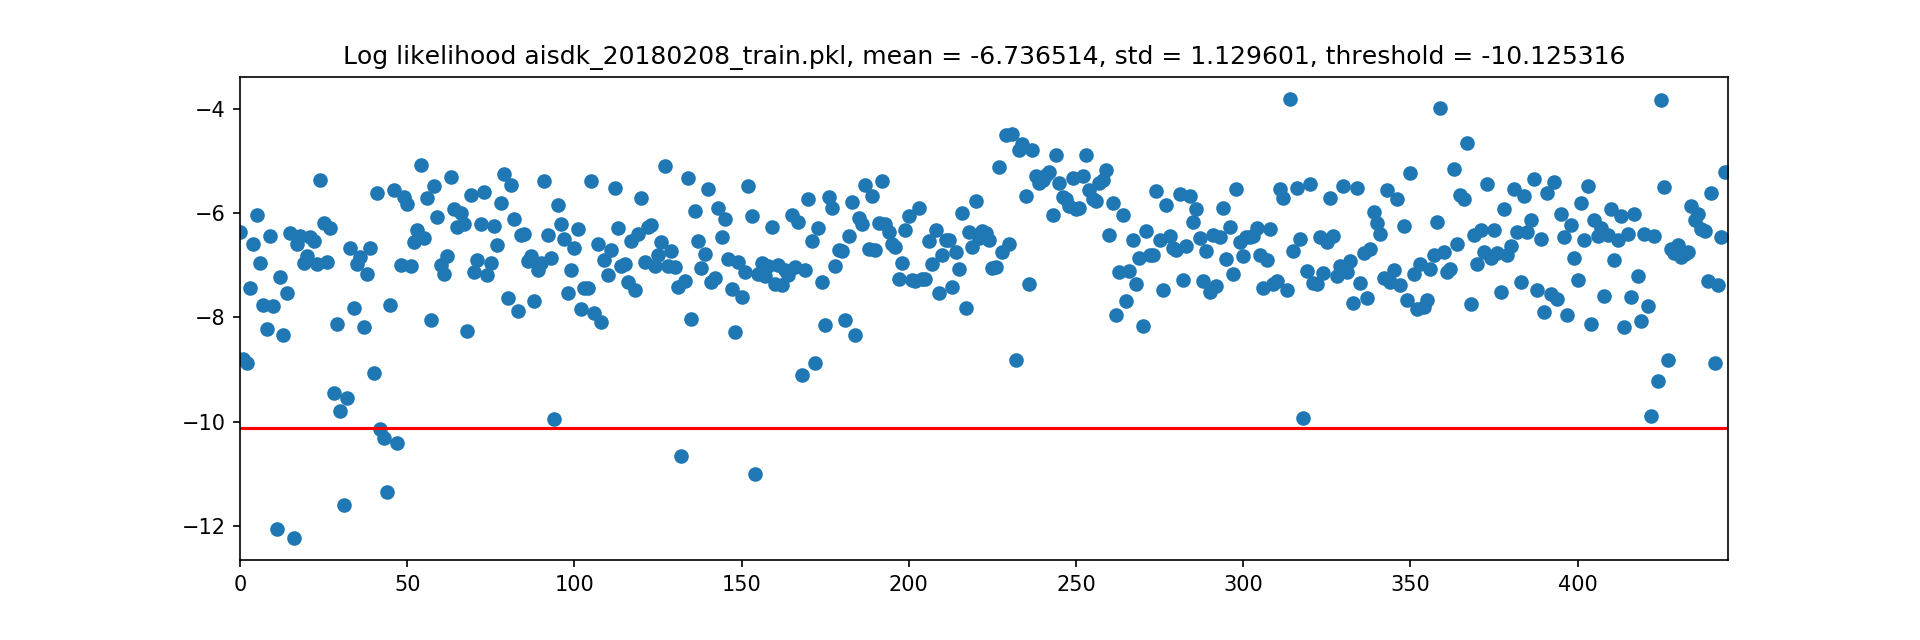

In [10]:
from IPython.display import Image
Image(filename=fig_name) 

##### local_logprob

In [11]:
import mobiml.models.geotracknet.utils as utils

LOGPROB_MEAN_MIN = -10.0
LOGPROB_STD_MAX = 5

LAT_RANGE = config.lat_max - config.lat_min
LON_RANGE = config.lon_max - config.lon_min
FIG_W = 960
FIG_H = int(FIG_W*LAT_RANGE/LON_RANGE)

m_map_logprob_std = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
m_map_logprob_mean = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
m_map_density = np.zeros(shape=(config.n_lat_cells,config.n_lon_cells))
v_logprob = np.empty((0,))
v_mmsi = np.empty((0,))
Map_logprob = dict()
for row  in range(config.n_lat_cells):
    for col in range(config.n_lon_cells):
        Map_logprob[ str(str(row)+","+str(col))] = []

# Load logprob
with open(outputs_path,"rb") as f:
    l_dict = pickle.load(f)

print("Calculating the logprob map...")
for D in tqdm(l_dict):
    tmp = D["seq"]
    log_weights_np = D["log_weights"]
    for d_timestep in range(2*6,len(tmp)):
        try:
            row = int(tmp[d_timestep,0]*0.01/config.cell_lat_reso)
            col = int((tmp[d_timestep,1]-config.onehot_lat_bins)*0.01/config.cell_lat_reso)
            Map_logprob[str(row)+","+str(col)].append(np.mean(log_weights_np[d_timestep,:]))
        except:
            continue

# Remove outliers
for row  in range(config.n_lat_cells):
    for col in range(config.n_lon_cells):
        s_key = str(row)+","+str(col) 
        Map_logprob[s_key] = utils.remove_gaussian_outlier(np.array(Map_logprob[s_key]))
        m_map_logprob_mean[row,col] = np.mean(Map_logprob[s_key])
        m_map_logprob_std[row,col] = np.std(Map_logprob[s_key])
        m_map_density[row,col] = len(Map_logprob[s_key])

# Save to disk
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(save_dir+"map_density-"+str(config.cell_lat_reso)+"-"+str(config.cell_lon_reso),m_map_density)
with open(os.path.join(save_dir,"Map_logprob-"+str(config.cell_lat_reso)+"-"+str(config.cell_lon_reso)+".pkl"),"wb") as f:
    pickle.dump(Map_logprob,f)

# Show the map
utils.show_logprob_map(m_map_logprob_mean, m_map_logprob_std, save_dir, 
                        logprob_mean_min = LOGPROB_MEAN_MIN,
                        logprob_std_max = LOGPROB_STD_MAX,
                        fig_w = FIG_W, fig_h = FIG_H,
                        )    

print(f'Maps stored saved to: {os.path.join(save_dir, "logprob_std_map.png")}')

  3%|▎         | 13/445 [00:00<00:03, 126.39it/s]

Calculating the logprob map...


100%|██████████| 445/445 [00:02<00:00, 209.03it/s]
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/romeo/minico

/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/romeo/miniconda3/envs/mobiml_train/lib/python3.6/site-packages/

Maps stored saved to: results/simulated_sample/local_logprob-aisdk_20180208_train.pkl-aisdk_20180208_train.pkl-100-missing_data-False-step-1002/logprob_std_map.png


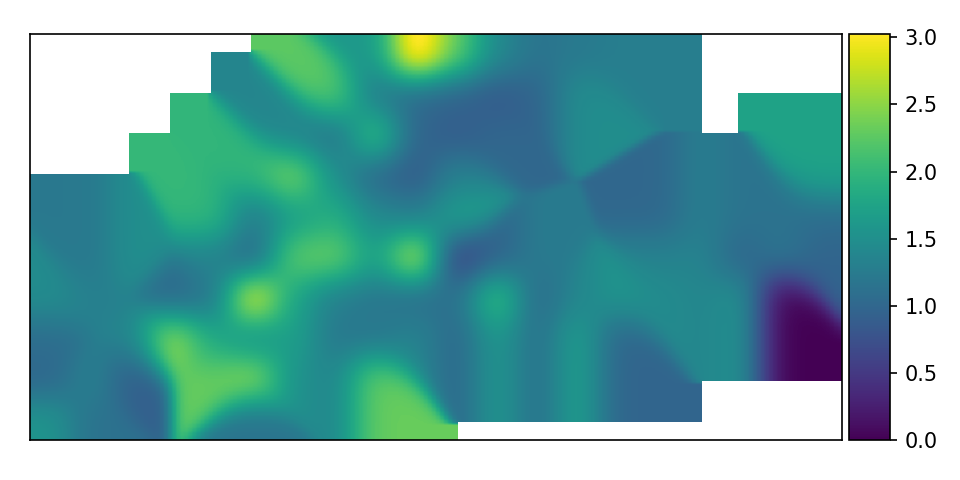

In [12]:
Image(filename=os.path.join(save_dir, "logprob_std_map.png")) 

##### contrario_detection

In [13]:
import csv
from scipy import stats
from datetime import datetime
import mobiml.models.geotracknet.contrario_utils as contrario_utils

with open(os.path.join(save_dir,"Map_logprob-"+\
            str(config.cell_lat_reso)+"-"+str(config.cell_lat_reso)+".pkl"),"rb") as f:
    Map_logprob = pickle.load(f)
# Load the logprob
with open(outputs_path,"rb") as f:
    l_dict = pickle.load(f)
d_i = 0
v_mean_log = []
l_v_A = []
v_buffer_count = []
length_track = len(l_dict[0]["seq"])
l_dict_anomaly = []
n_error = 0
for D in tqdm(l_dict):
    try:
    # if True:
        tmp = D["seq"]
        m_log_weights_np = D["log_weights"]
        v_A = np.zeros(len(tmp))
        for d_timestep in range(2*6,len(tmp)):
            d_row = int(tmp[d_timestep,0]*config.onehot_lat_reso/config.cell_lat_reso)
            d_col = int((tmp[d_timestep,1]-config.onehot_lat_bins)*config.onehot_lat_reso/config.cell_lon_reso)
            d_logprob_t = np.mean(m_log_weights_np[d_timestep,:])

            # KDE
            l_local_log_prod = Map_logprob[str(d_row)+","+str(d_col)]
            if len(l_local_log_prod) < 2:
                v_A[d_timestep] = 2
            else:
                kernel = stats.gaussian_kde(l_local_log_prod)
                cdf = kernel.integrate_box_1d(-np.inf,d_logprob_t)
                if cdf < 0.1:
                    v_A[d_timestep] = 1
        v_A = v_A[12:]
        v_anomalies = np.zeros(len(v_A))
        for d_i_4h in range(0,len(v_A)+1-24):
            v_A_4h = v_A[d_i_4h:d_i_4h+24]
            v_anomalies_i = contrario_utils.contrario_detection(v_A_4h,config.contrario_eps)
            v_anomalies[d_i_4h:d_i_4h+24][v_anomalies_i==1] = 1

        if len(contrario_utils.nonzero_segments(v_anomalies)) > 0:
            D["anomaly_idx"] = v_anomalies
            l_dict_anomaly.append(D)
    except:
        n_error += 1
print("Number of processed tracks: ",len(l_dict))
print("Number of abnormal tracks: ",len(l_dict_anomaly)) 
print("Number of errors: ",n_error)

# Save to disk
n_anomalies = len(l_dict_anomaly)
save_filename = os.path.basename(config.trainingset_name)\
                +"-" + os.path.basename(config.trainingset_name)\
                +"-" + str(config.latent_size)\
                +"-missing_data-"+str(config.missing_data)\
                +"-step-"+str(step)\
                +".pkl"
save_pkl_filename = os.path.join(save_dir,"List_abnormal_tracks-"+save_filename)
with open(save_pkl_filename,"wb") as f:
    pickle.dump(l_dict_anomaly,f)

## Plot
with open(config.trainingset_path,"rb") as f:
    Vs_train = pickle.load(f)
with open(config.testset_path,"rb") as f:
    Vs_test = pickle.load(f)

save_filename = "Abnormal_tracks"\
            + "-" + os.path.basename(config.trainingset_name)\
            + "-" + os.path.basename(config.testset_name)\
            + "-latent_size-" + str(config.latent_size)\
            + "-step-"+str(step)\
            + "-eps-"+str(config.contrario_eps)\
            + "-" + str(n_anomalies)\
            + ".png"

# Plot abnormal tracks with the tracks in the training set as the background
utils.plot_abnormal_tracks(Vs_train,l_dict_anomaly,
                    os.path.join(save_dir,save_filename),
                    config.lat_min,config.lat_max,config.lon_min,config.lon_max,
                    config.onehot_lat_bins,config.onehot_lon_bins,
                    background_cmap = "Blues",
                    fig_w = FIG_W, fig_h = FIG_H,
                )
plt.close()
# Plot abnormal tracks with the tracks in the test set as the background
utils.plot_abnormal_tracks(Vs_test,l_dict_anomaly,
                    os.path.join(save_dir,save_filename.replace("Abnormal_tracks","Abnormal_tracks2")),
                    config.lat_min,config.lat_max,config.lon_min,config.lon_max,
                    config.onehot_lat_bins,config.onehot_lon_bins,
                    background_cmap = "Greens",
                    fig_w = FIG_W, fig_h = FIG_H,
                )
plt.close()   
# Save abnormal tracks to csv file
with open(os.path.join(save_dir,save_filename.replace(".png",".csv")),"w") as f:
    writer = csv.writer(f)
    writer.writerow(["MMSI","Time_start","Time_end","Timestamp_start","Timestamp_end"])
    for D in l_dict_anomaly:
        writer.writerow([D["mmsi"],
            datetime.utcfromtimestamp(D["t_start"]).strftime('%Y-%m-%d %H:%M:%SZ'),
            datetime.utcfromtimestamp(D["t_end"]).strftime('%Y-%m-%d %H:%M:%SZ'),
            D["t_start"],D["t_end"]])
        
print(f'Maps stored saved to: {save_dir}')

100%|██████████| 445/445 [04:22<00:00,  1.70it/s]


Number of processed tracks:  445
Number of abnormal tracks:  67
Number of errors:  0
Maps stored saved to: results/simulated_sample/local_logprob-aisdk_20180208_train.pkl-aisdk_20180208_train.pkl-100-missing_data-False-step-1002/


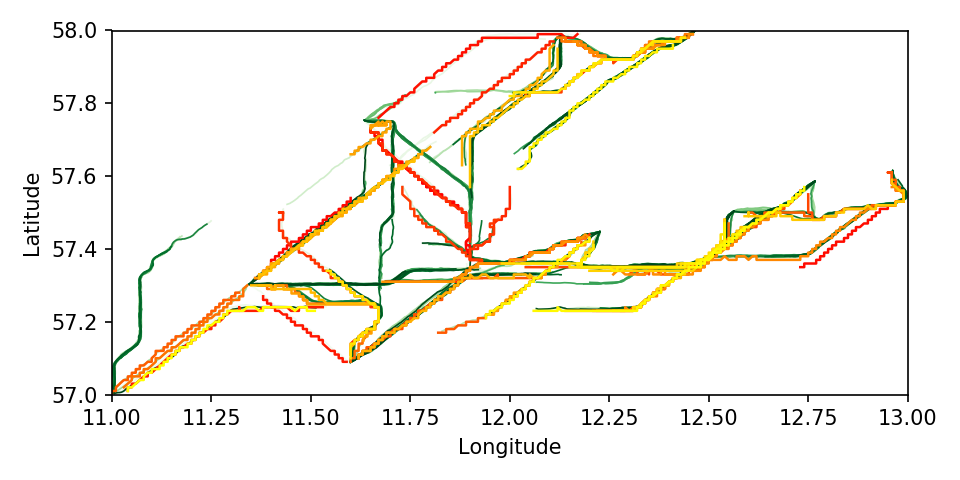

In [14]:
Image(filename=os.path.join(save_dir,save_filename.replace("Abnormal_tracks","Abnormal_tracks2"))) 